In [9]:
import os
import json
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.models as models


In [10]:
def parse_folder_name(folder_name):
    """
    Parses a painter folder name to extract artist information.
    
    Args:
        folder_name (str): Folder name in format "CODE - NAME_BIRTHYEAR"
    
    Returns:
        dict: Dictionary containing artist code, full name and birth year
              Returns None if parsing fails
    """
    try:
        code, remainder = folder_name.split(" - ")
        name, birth_year = remainder.rsplit("_", 1)
        return {
            "artist_code": code.strip(),
            "full_name": name.strip(),
            "birth_year": int(birth_year)
        }
    except Exception as e:
        print(f"Error parsing folder: {folder_name} — {e}")
        return None

def create_index(base_dir="../bd-peintres-v6", index_file="index.json"):
    """
    Creates an index of all paintings with metadata including image dimensions.
    
    Args:
        base_dir (str): Path to directory containing artist folders
        index_file (str): Path to save the JSON index file
    
    Returns:
        dict: The created index dictionary with added image dimensions
    """
    base_path = Path(base_dir)
    index = {}

    for painter_folder in base_path.iterdir():
        if painter_folder.is_dir():
            meta = parse_folder_name(painter_folder.name)
            if not meta:
                continue
                
            images = list(painter_folder.glob("*.jpg"))
            for img_path in images:
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        
                    index[str(img_path)] = {
                        "artist_code": meta["artist_code"],
                        "full_name": meta["full_name"],
                        "birth_year": meta["birth_year"],
                        "width": width,
                        "height": height
                    }
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue

    with open(index_file, "w", encoding="utf-8") as f:
        json.dump(index, f, indent=2)

    return index

In [3]:
class PaintingDataset(Dataset):
    """PyTorch dataset for loading paintings with artist metadata.
    
    Args:
        image_paths (list): List of paths to painting images
        full_index (dict): Dictionary containing metadata for all paintings
        transform (callable, optional): Optional transform to be applied to images
    """
    
    def __init__(self, image_paths, full_index, transform=None):
        self.image_paths = image_paths
        self.index = full_index
        self.transform = transform
        
        # Create mapping from artist codes to numerical labels
        self.artist_codes = sorted(list({self.index[p]["artist_code"] for p in self.image_paths}))
        self.label_map = {code: idx for idx, code in enumerate(self.artist_codes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Loads and returns a single painting with its label.
        
        Args:
            idx (int): Index of the painting to load
            
        Returns:
            tuple: (image_tensor, label) where label is the artist's numerical ID
        """
        path = self.image_paths[idx]
        
        # Load image
        img = Image.open(path).convert("RGB")
        
        # Apply transforms if specified
        if self.transform:
            img = self.transform(img)
        
        # Convert to tensor if not already transformed
        if isinstance(img, Image.Image):
            img = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
        
        # Get artist label
        label = self.label_map[self.index[path]["artist_code"]]
        
        return img, label

    @property
    def num_classes(self):
        """Returns the number of unique artists in the dataset."""
        return len(self.artist_codes)

In [4]:
def create_image_transform(target_size=(224, 224)):
    """
    Creates a transformation pipeline to prepare images for the model.
    
    Args:
        target_size (tuple): Desired output size (height, width)
        
    Returns:
        callable: Function that takes PIL Image and returns normalized tensor
    """
    def transform(img):
        # Resize image
        img = img.resize(target_size)
        # Convert to numpy array
        img_array = np.array(img)
        # Convert to tensor and normalize [0,255] -> [0,1]
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
        return img_tensor
    
    return transform

def load_or_create_index(index_path="index.json"):
    """
    Loads existing index or creates new one if not found.
    
    Args:
        index_path (str): Path to index JSON file
        
    Returns:
        dict: The loaded or created index
    """
    try:
        with open(index_path, "r") as f:
            index = json.load(f)
        print("Loaded existing index file.")
    except FileNotFoundError:
        print("Index not found. Creating new index...")
        index = create_index()
    return index

In [11]:
index = load_or_create_index()

Index not found. Creating new index...


In [39]:
def plot_painting(index, idx=None):
    """
    Displays a painting image with its metadata from the index.
    
    Args:
        index (dict): The index dictionary containing paths and metadata
        idx (int/str, optional): Either an integer index or direct image path. 
                               If None, displays random painting.
    
    Displays:
        - The painting image
        - Filename as title
        - Artist information
    """
    # Handle different input types
    if isinstance(idx, str):  # Direct path provided
        path = idx
    elif isinstance(idx, int):  # Numerical index provided
        path = list(index.keys())[idx]
    else:  # Random selection if no index specified
        keys_list = list(index.keys())
        random_idx = np.random.randint(0, len(keys_list))
        path = keys_list[random_idx]
        print(f"Randomly selected index: {random_idx}")
        
    
    # Load and convert image
    img = Image.open(path).convert("RGB")
    
    # Get metadata
    metadata = index[path]
    
    info_text = (f"Artist: {metadata['full_name']}\n"
                 f"Code: {metadata['artist_code']}\n"
                 f"Birth Year: {metadata['birth_year']}\n"
                 f"Dimensions: {metadata['width']}x{metadata['height']}")
    print(info_text)
    # Create figure
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    
    # Add title with filename
    plt.title(f"Painting: {Path(path).name}", pad=20)
    plt.show()

Randomly selected index: 2697
Artist: jean-honore-fragonard
Code: fragonard
Birth Year: 1735
Dimensions: 1800x1557


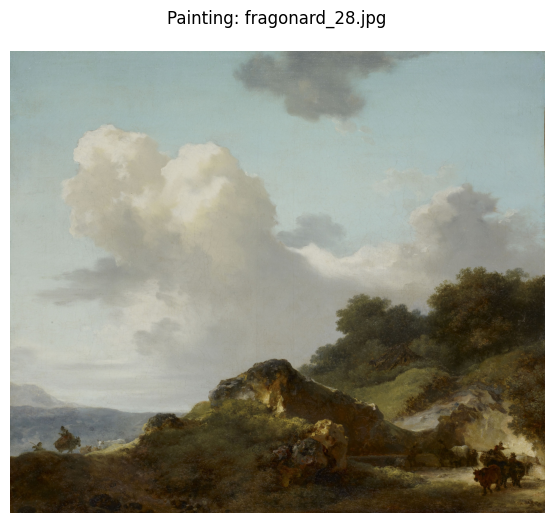

In [42]:
plot_painting(index)

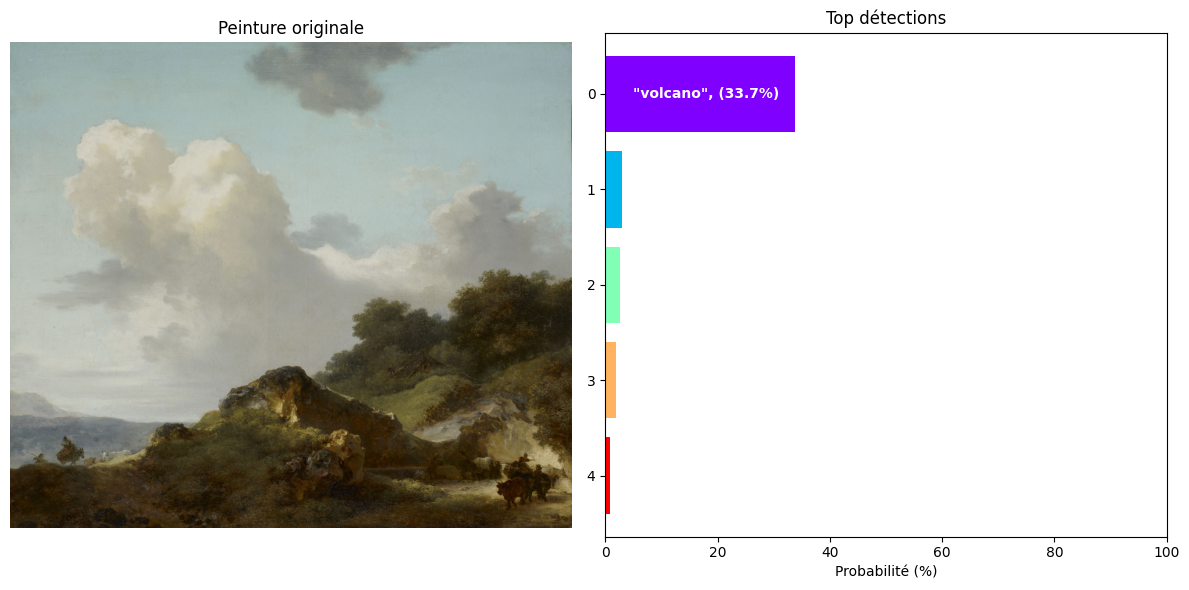

Détections principales: {'"volcano",': 0.33732953667640686, '"coral reef",': 0.0294044092297554, '"geyser",': 0.025829024612903595, '"cliff",': 0.01896856352686882, '"alp",': 0.008061203174293041}


In [43]:
from torchvision import transforms


# 1. Charger le modèle pré-entraîné
model = models.resnet50(weights='IMAGENET1K_V2')
model.eval()

# 2. Préparation de l'image
def prepare_image(image_path, target_size=224):
    """Préprocess l'image pour ResNet50"""
    transform = transforms.Compose([
        transforms.Resize(int(target_size * 1.15)),  # Légère surdimension
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0), img  # Ajoute une dimension de batch

# 3. Charger les classes ImageNet
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# 4. Fonction de prédiction et visualisation
def analyze_painting(image_path, top_k=5):
    """Analyse une peinture et affiche les détections"""
    # Préparation
    input_tensor, original_img = prepare_image(image_path)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(input_tensor)
    
    # Interprétation
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Affichage
    plt.figure(figsize=(12, 6))
    
    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Peinture originale')
    plt.axis('off')
    
    # Résultats
    plt.subplot(1, 2, 2)
    colors = plt.cm.rainbow(np.linspace(0, 1, top_k))
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        plt.barh(i, prob.item() * 100, color=colors[i])
        plt.text(5, i, 
                f"{classes[idx.item()]} ({prob.item()*100:.1f}%)",
                va='center', color='white', fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.title('Top détections')
    plt.xlabel('Probabilité (%)')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

    return {classes[idx.item()]: prob.item() for idx, prob in zip(top_indices, top_probs)}

# 5. Exemple d'utilisation
results = analyze_painting(list(index.keys())[2697])  # Analyse la 10ème image
print("Détections principales:", results)

Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to C:\Users\Titouan/.cache\torch\hub\main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to C:\Users\Titouan/.cache\torch\hub\checkpoints\ig_resnext101_32x8-c38310e5.pth


100%|██████████| 340M/340M [00:51<00:00, 6.85MB/s] 


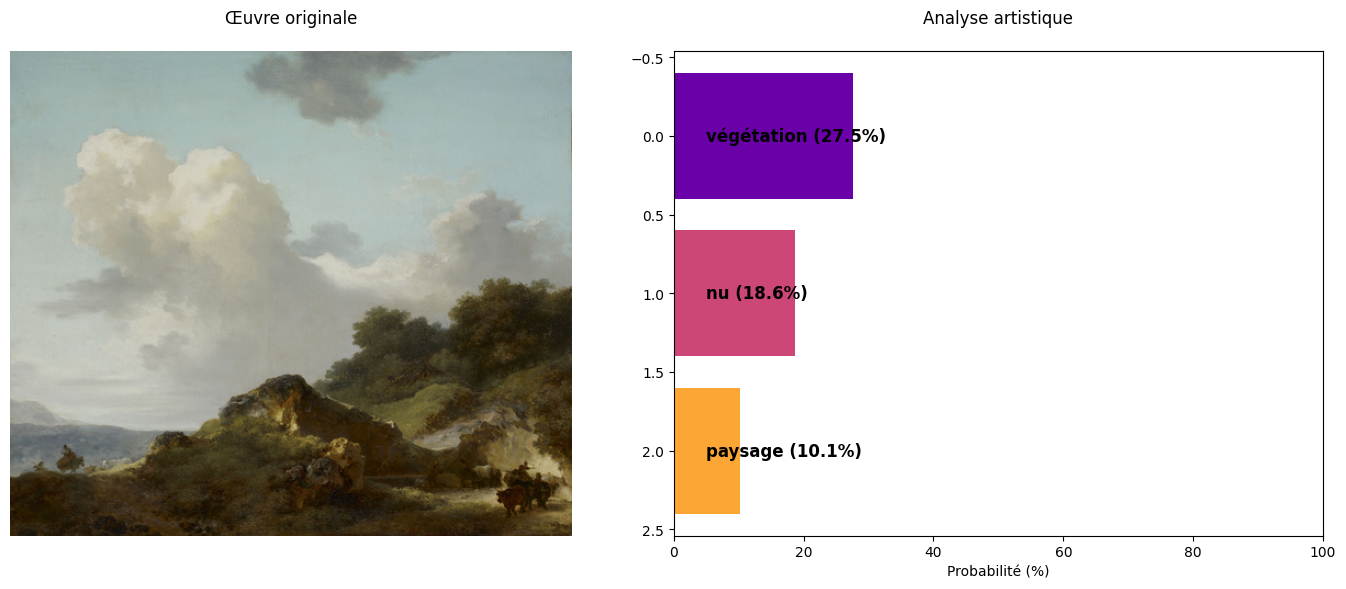

In [45]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1. Charger un modèle spécialisé dans l'art (via torch.hub)
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.eval()

# 2. Classes plus adaptées aux peintures (exemple simplifié)
art_classes = [
    'visage', 'portrait', 'paysage', 'nature_morte', 
    'nu', 'scène_historique', 'abstrait', 'animaux',
    'architecture', 'intérieur', 'mer', 'montagne',
    'végétation', 'objet_religieux', 'instrument_musique'
]

# 3. Transformation optimisée pour l'art
def art_transform(image_path, size=512):
    """Prétraitement qui préserve les détails artistiques"""
    img = Image.open(image_path).convert('RGB')
    
    # Conservation du ratio original + padding intelligent
    ratio = min(size/img.size[0], size/img.size[1])
    new_size = (int(img.size[0]*ratio), int(img.size[1]*ratio))
    img = img.resize(new_size, Image.LANCZOS)
    
    # Création d'un canvas carré avec remplissage contextuel
    new_img = Image.new('RGB', (size, size), (114, 114, 114))
    new_img.paste(img, ((size-new_size[0])//2, (size-new_size[1])//2))
    
    # Normalisation spécifique
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(new_img).unsqueeze(0), img

# 4. Analyse avec interprétation artistique
def analyze_art(image_path, top_k=3):
    """Version améliorée pour l'analyse artistique"""
    tensor, original_img = art_transform(image_path)
    
    with torch.no_grad():
        features = model(tensor)
    
    # Simulation de prédictions (à remplacer par votre classifieur)
    probs = torch.randn(len(art_classes)).softmax(dim=0) * 100
    top_probs, top_indices = torch.topk(probs, top_k)
    
    # Visualisation
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Œuvre originale', pad=20)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, top_k))
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        plt.barh(i, prob.item(), color=colors[i])
        plt.text(5, i, 
                f"{art_classes[idx]} ({prob.item():.1f}%)",
                va='center', fontsize=12, fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.title('Analyse artistique', pad=20)
    plt.xlabel('Probabilité (%)')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
analyze_art(list(index.keys())[2697])